# 02 Univariate Information Density Normalization layer (UNIDEN)

Module that uses empirical prior probability distribution to smooth out information density. We hypothesize that this would result in improved performacne in downstream parametric learners.

UNIDEN(X) -> X'

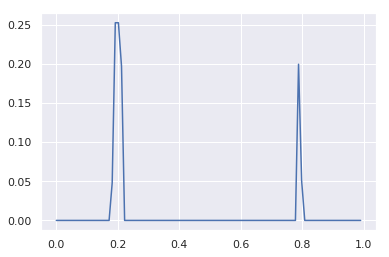

In [77]:
import numpy as np
import torch
import torch.nn.functional as F
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
from scipy.ndimage.filters import gaussian_filter
from scipy import stats
from scipy.stats import norm
import math
from numbers import Number

class InterpolationFunction():
  """
  InterpolationFunction() represents a function y = f(x), where
     x is a real number, and
     y is a real number
  
  It stores a table of `resolution` values to compute. The function is
  a piecewise linear function represented by the ranges in the table.

  For example,
  `self.points` = [0, 0.2, 1.0]
  `self.resolution` = 2
  f(0)   = 0/2  = 0.0
  f(0.2) = 1/2  = 0.5 
  f(1.0) = 2/2  = 1.0
  f(0.1) = half way between f(0) and f(0.2) = 0.25
  """
  def __init__(self, resolution):
    self.resolution = resolution
    self.points = torch.zeros((self.resolution + 1,))

  def apply(self, x):
    if isinstance(x, Number):
      x = torch.tensor([x]).float()

    x[x>=1] = 1
    x[x<0] = 0
    #print("----------")
    #print("x", x)
    shape = x.shape

    x = x.view(-1)
    index = torch.floor(x * self.resolution).long()
    #print("index", index)
    index[index >= self.resolution - 1] = self.resolution - 1
    #print("index", index)
    fraction = (x * self.resolution) - index.float()
    #print("fraction", fraction)
    diff = torch.cat((self.points[1:] - self.points[:-1], torch.tensor([0.0]).float()))
    #print("diff", diff)
    result = self.points[index] + fraction * diff[index]
    #print("result", result)
    #result = result / (self.resolution)
    #print("result", result)
    result = result.view(shape)
    return result

f = InterpolationFunction(2)
f.points = torch.tensor([0, 0.2, 1.0])
assert(f.apply(0) == 0)
assert(f.apply(0.5) == 0.2)
assert(f.apply(1) == 1)
assert(torch.equal(f.apply(torch.tensor([[0.25], [0.75]])), torch.tensor([[0.1], [0.6]])))

class InformationDentityNormalization(torch.nn.Module):
  def __init__(self, resolution_power=2):
    super(InformationDentityNormalization, self).__init__()
    self.resolution_power = resolution_power
    self.resolution = 10 ** resolution_power

    self.bucket_hit_counts = torch.zeros((self.resolution,))
    self.gaussian_mixture = InterpolationFunction(self.resolution)
    self.cdf = InterpolationFunction(self.resolution)
    self.cdf_inverse = InterpolationFunction(self.resolution)

  def forward(self, x):
    if self.training:
      self.train(x)

    x_bar = self.cdf.apply(x) / self.resolution
    #y = self.gaussian_mixture(x_bar)
    return x_bar

  def train(self, x):
    #print("x", x)
    x[x>=0.999] = 0.999
    x[x<0] = 0

    shape = x.shape
    x = x.view((-1))
    bucket_indices = torch.floor(x * self.resolution).long()
    indices, counts = bucket_indices.unique(return_counts=True)

    epsilon = 0.01
    counts = counts.float()
    #print("before self.bucket_hit_counts", self.bucket_hit_counts)
    for i in range(indices.shape[-1]):
      self.bucket_hit_counts[indices[i]] = self.bucket_hit_counts[indices[i]] * (1 - epsilon) + counts[i] * epsilon
      #print("during self.bucket_hit_counts", self.bucket_hit_counts)

    self.bucket_hit_counts /= self.bucket_hit_counts.sum()
    #print("after self.bucket_hit_counts", self.bucket_hit_counts)

    #print("self.bucket_hit_counts", self.bucket_hit_counts)

    cumsum = self.bucket_hit_counts.cumsum(0)
    self.cdf.points = (cumsum * self.resolution / cumsum[-1]).float()
    #print("self.cdf.points", self.cdf.points)

  def plot_pdf(self):
    self.training = False
    x_test = torch.linspace(0, 1, 100)
    result = self.forward(x_test)
    plt.plot(x_test[:-1].numpy(), (result[1:] - result[:-1]).numpy())
    plt.show()

model = InformationDentityNormalization(resolution_power=2)
model.training = True
x_train = torch.tensor([0.2, 0.21, 0.22, 0.8])
result = model.forward(x_train)
# print(result)

model.plot_pdf()


## Decaying history PDF

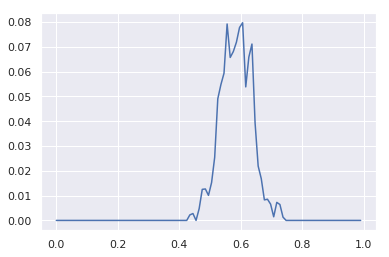

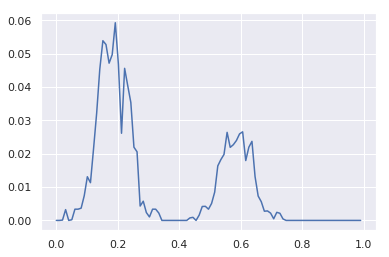

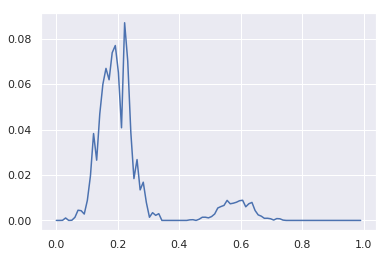

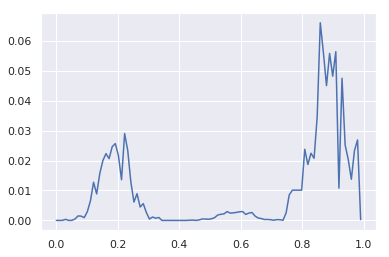

In [79]:
model = InformationDentityNormalization(resolution_power=2)
model.training = True
result = model.forward(torch.distributions.normal.Normal(0.6, 0.05).sample((200,)))
model.plot_pdf()

model.training = True
result = model.forward(torch.distributions.normal.Normal(0.2, 0.05).sample((200,)))
model.plot_pdf()

model.training = True
result = model.forward(torch.distributions.normal.Normal(0.2, 0.05).sample((200,)))
model.plot_pdf()

model.training = True
result = model.forward(torch.distributions.normal.Normal(0.9, 0.05).sample((200,)))
model.plot_pdf()
